# 🦠 COVID-19 Classification 😷

COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources.
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

Brazil is one of the countries most affected by the COVID-19 pandemic, with more than 16 million confirmed cases and 454 429 confirmed deaths by May 26, 2021 (according to the Johns Hopkins Coronavirus Resource Center). 

Brazil was and still is one of the countries most impacted by the first wave of Covid-19 which first recorded case on 26th February 2020 and reached community transmission from 20th March 2019 onwards to dates, that caught Brazil unprepared and unable to response due to the strain on hospital capacity such as the intense and lengthy request for ICU (incentive care unit) beds, professionals, personal protection equipment and healthcare resources.

This dataset contains anonymized data from Hospital Sírio-Libanês, São Paulo and Brasilia. All data were anonymized following the best international practices and recommendations.
Data has been cleaned and scaled by column according to **MinMaxScaler** to fit between -1 and 1.

## Initial imports
In this section we will set up the libraries that will be used in the notebook and open the data.

In [ ]:
# Used to access the dataset on personal Google Drive
from google.colab import drive

# Used for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Used for visualizing missing data
import missingno as msno

# Used for data preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from collections import Counter

# Used for metrics
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

# Used for models
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
# Explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Remove notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Change the path to your own path
path = "/content/drive/My Drive/Colab Notebooks/Practice/Datasets/COVID-19/Classification/"

# Load the file - add the file's name
data = pd.read_excel(path+"data.xlsx")

Duplicates could be an issue and cause overfitting. We will have to deal with this issue. Let's first see if the data has any duplicates and remove them.

In [ ]:
print("Data before drop_duplicates:", data.shape)
data = data.drop_duplicates()
print("Data after drop_duplicates:", data.shape)

Data before drop_duplicates: (1925, 231)
Data after drop_duplicates: (1925, 231)


## Exploratory Data Analysis
Exploratory Data Analysis (EDA) will allow us to form and establish hypotheses of predictive insights on the data. This will allow us to correctly prepare the data and develop then develop machine learning models that according to the initially formed hypotheses.

In [ ]:
# Initial data column information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB
None


In [ ]:
# Let's visualize the data columns and see what the data looks like
data.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

In [ ]:
data.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

Compared to the **COVID-19 forecasting** dataset, this dataset is contains majority numerical data.

### Missing data
In order for us to develop machine learning models, we have to explore and deal with the missing data. This will allow us to make more accurate models and predictions.

#### Missing data information
Let's check which columns have missing data for all of the data - train, test and submission.

There are 231 columns and it will be difficult to visualize them. Let's further investigate the data.

In [ ]:
# Get every column and the missing values
missing = pd.DataFrame(data=data.columns, columns=['Names'])

missing['Missing Values'] = data.isna().sum().values

missing_columns = missing[missing['Missing Values'] > 0].shape[0]
missing_percentage = round((missing_columns / data.shape[1]) * 100)
print("Columns that have NaN data:\t{} ({}%)" .format(missing_columns, missing_percentage))

Columns that have NaN data:	225 (97%)


#### Missign data exploration
We will use the `missingno` library in order to quickly and easily visualize the missing data and how it is spread within the dataset. We will using `missingno` barplot, heatmap, matrix and dendogram in order for us to inspect any relations between missing data. However visualizing the missing data will be difficult because 97% of the columns have missing data and there are 231 columns.

##### Barplot
A barplot will allow us to see how many values are missing for every column. 

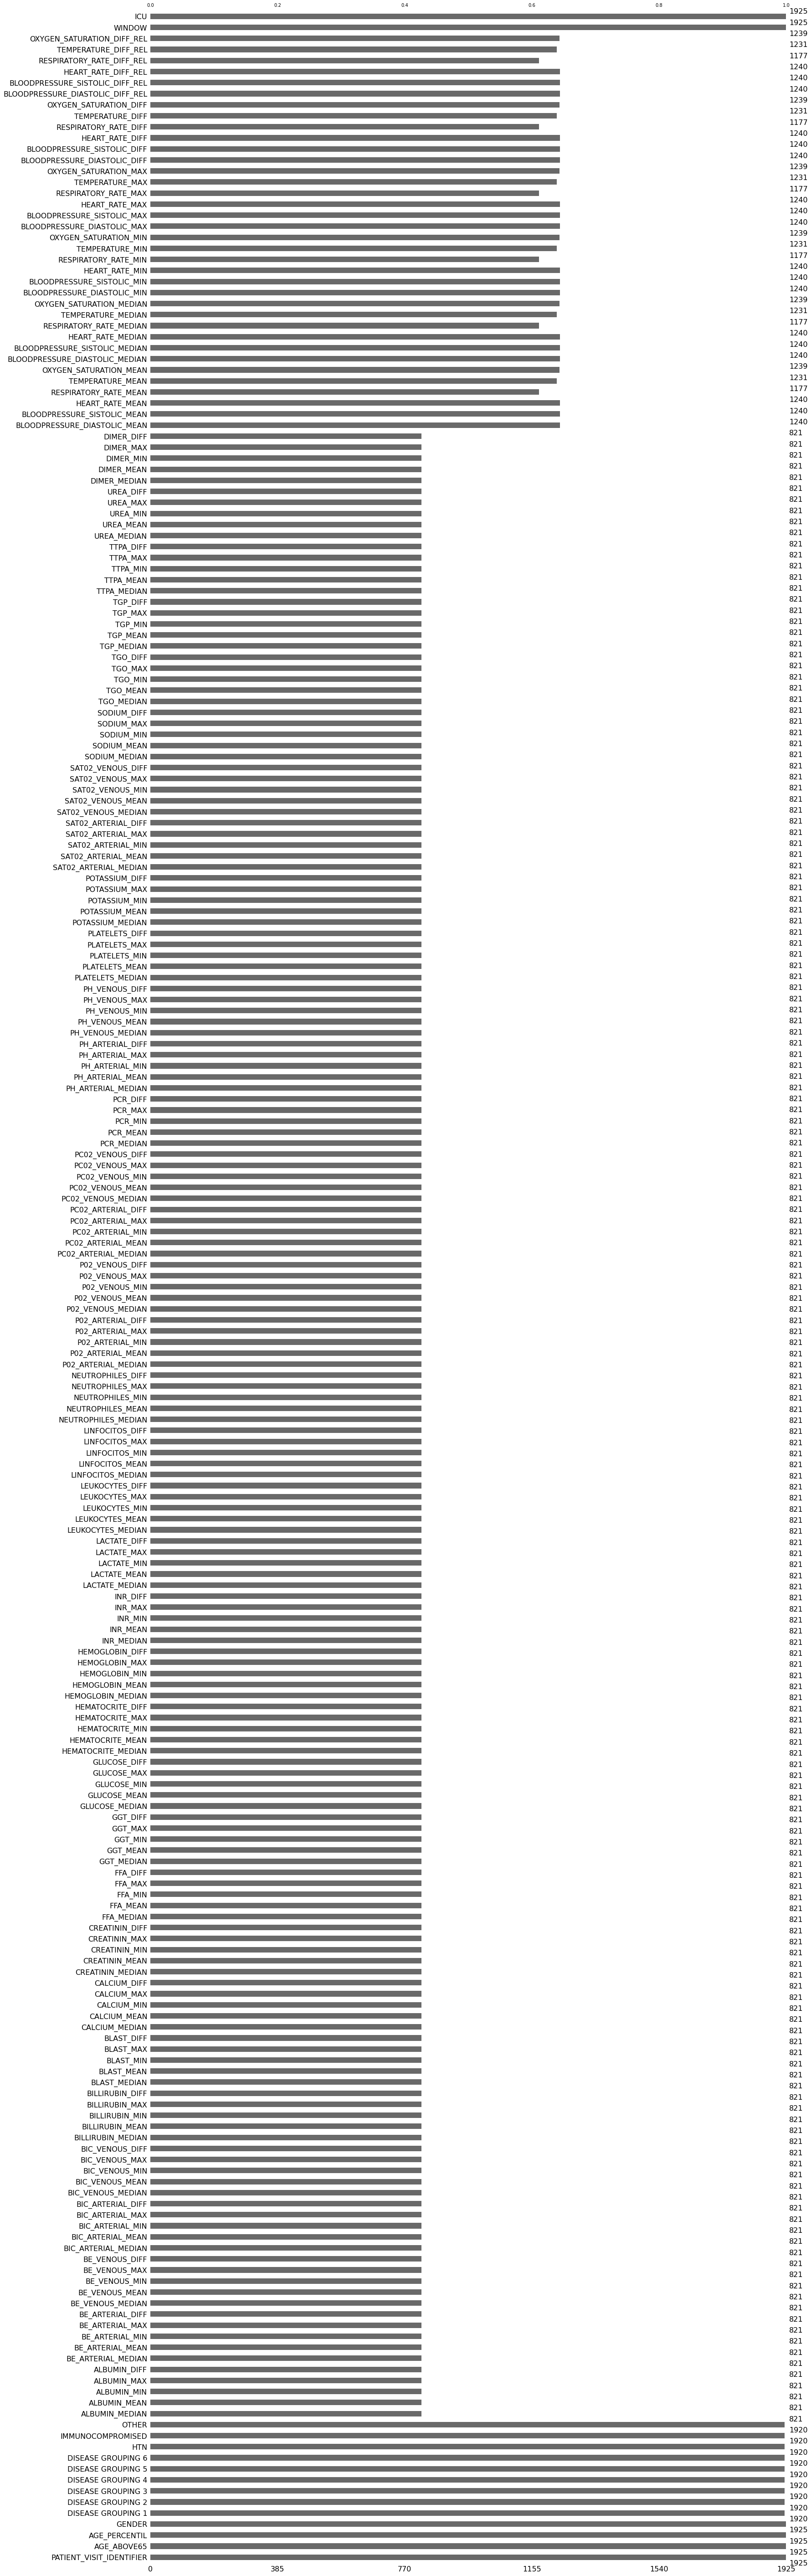

In [ ]:
msno.bar(data)
plt.show()

As mentioned above, 97% of the columns have missing data.

##### Dendogram
A dendogram allows us to see how the missing data is related with each other.

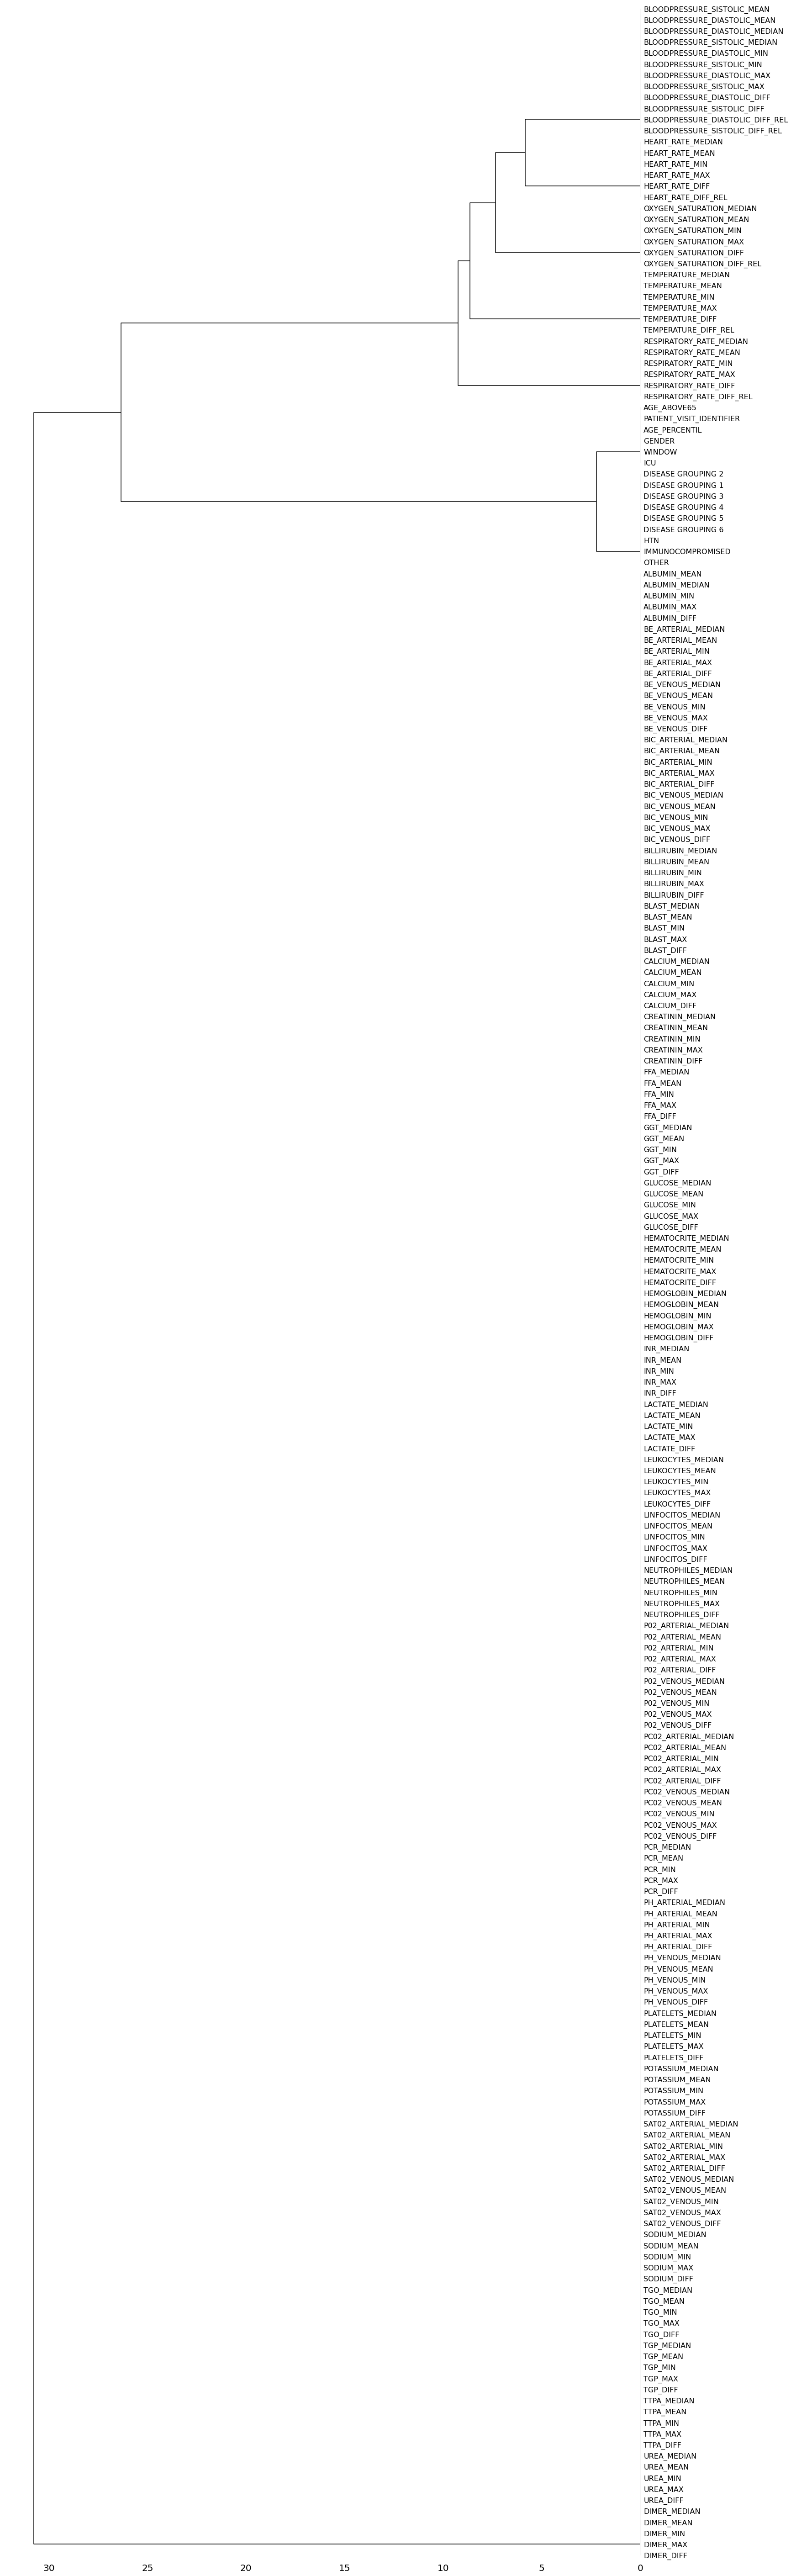

In [ ]:
msno.dendrogram(data)
plt.show()

#### Can we drop the NaN columns rather than imputing them?
There are two ways of dealing with missing data - either dropping all of the **NaN** columns or imputting data. The dataset is quite small and dropping the **NaN** rows could have a huge impact.

In [ ]:
total_rows = data.shape[0]
after_drop_rows = data.dropna().shape[0]
print("Rows before dropna:\t{}\n" .format(total_rows))
print("Rows after dropna:\t{} ({}%)" .format(after_drop_rows, round((after_drop_rows / total_rows) * 100)))

Rows before dropna:	1925

Rows after dropna:	545 (28%)


We will lose 72% of the dataset if we `dropna()` all of the **NaN** columns. We will have to impute the missing data.

#### Dealing with NaN values
In order to deal with **NaN** data, we will look at the **NaN** values on a patient level rather than using `KNNImputer` or `SimpleImputer`. As suggested on the dataset:

*It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows.*



In [ ]:
# Forward fill (ffill) the NaN values and then back fill (bfill) the remaining NaN values
def fill_nan(data):
    # Get the patient identifier
    PATIENT_VISIT_IDENTIFIER = data.PATIENT_VISIT_IDENTIFIER
    temp = data.sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW'])\
            .groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)\
            .fillna(method='ffill').fillna(method='bfill')
    # Re-add
    temp.insert(0, 'PATIENT_VISIT_IDENTIFIER', PATIENT_VISIT_IDENTIFIER)
    
    return temp

In [ ]:
data = fill_nan(data)

Now we have dealt with all of the **NaN** data in the dataset and we can move to visualizing the data.

In [ ]:
# Double check if the data has any NaN columns
data.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Data Visualization
By visualizing the data we can form hypotheses and get more insight from the data. It also allows us to start thinking about what kind of machine learning algorithms we might need to solve the dataset's problem.


#### **Is the dataset balanced or unbalanced?**
The target value for this dataset is **ICU**. If the target value is 1 then that means that the person has been taken to an **ICU**. If the target value is 0 then the patient has not been taken to an **ICU**.

[]

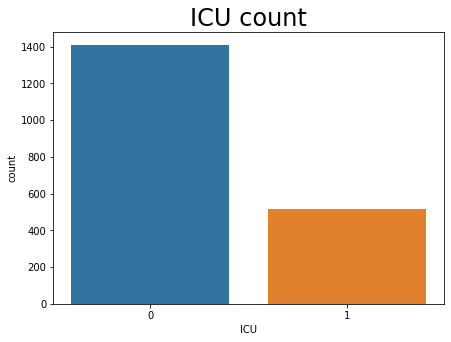

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('ICU count', fontsize=24, loc='center')
sns.countplot(data.ICU)
plt.plot()

The dataset is unbalanced and we will have to either use **SMOTE** or **Weights** on the models, so they can accurately predict if the patient needs an **ICU** or not.

#### **Which AGE_PERCENTIL has the most ICU target values?**
So far we know how that there are way more patients that do not need ICU than the ones they need. To better understand how the **ICU** values are split amongst patients, we will look at the patients age range.

[]

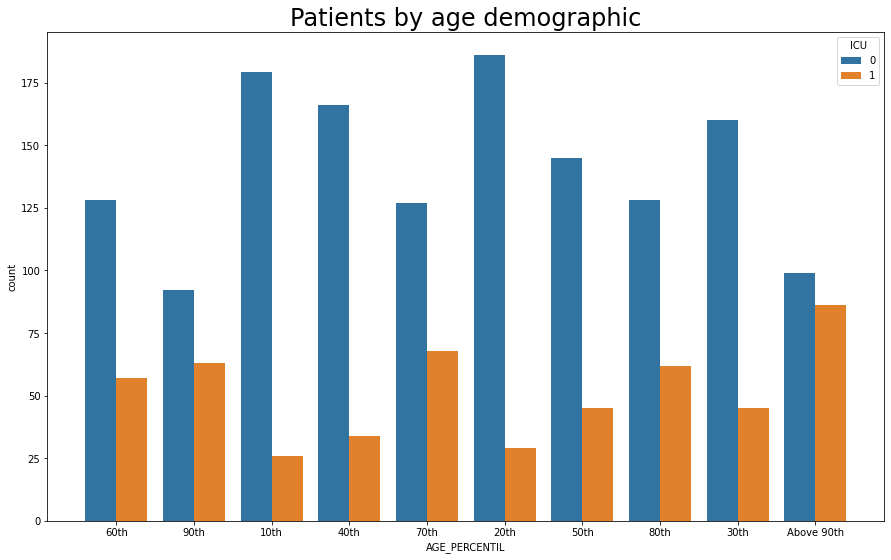

In [ ]:
plt.figure(figsize=(15, 9))
plt.title('Patients by age demographic', fontsize=24, loc='center')
sns.countplot(data.AGE_PERCENTIL, hue='ICU', data=data)
plt.plot()

#### **Does AGE_ABOVE65 matters for ICU target values?**
From the latter question it looks like the younger the patient's demographic is, the less they need an ICU. Let's investigate if it matters if the patient is above 65 or not, to double check if age a person's age matters for an **ICU**.

[]

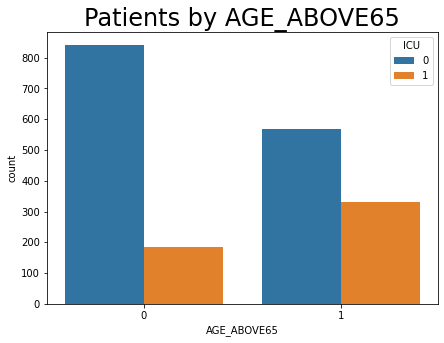

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('Patients by AGE_ABOVE65', fontsize=24, loc='center')
sns.countplot(data.AGE_ABOVE65, hue='ICU', data=data)
plt.plot()

The data confirms that the patioent's age plays a key role whether or not the patient needs an ICU.

#### **Which GENDER has the most ICU target values?**
We know how ICU is split based on people's age but we do not know the patients' gender and if a specific gender is more likely to get **ICU**.

[]

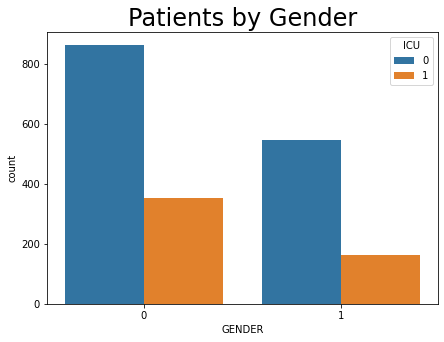

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('Patients by Gender', fontsize=24, loc='center')
sns.countplot(data.GENDER, hue='ICU', data=data)
plt.plot()

#### **Is there any relation between diseases and ICU?**
There are columns with diseases that patients have had before the ICU outcome. Although it does not mention the diseases names, patients with prior medical conditions have an increased risk of catching COVID-19.

In [ ]:
# Columns that refer to previous illness for patients
data.columns[3:12]

Index(['GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5',
       'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED'],
      dtype='object')

In [ ]:
diseases = data[['DISEASE GROUPING 1', 'DISEASE GROUPING 2','DISEASE GROUPING 3',
                    'DISEASE GROUPING 4','DISEASE GROUPING 5', 'DISEASE GROUPING 6',
                    'HTN','IMMUNOCOMPROMISED', 'OTHER', 'ICU']]

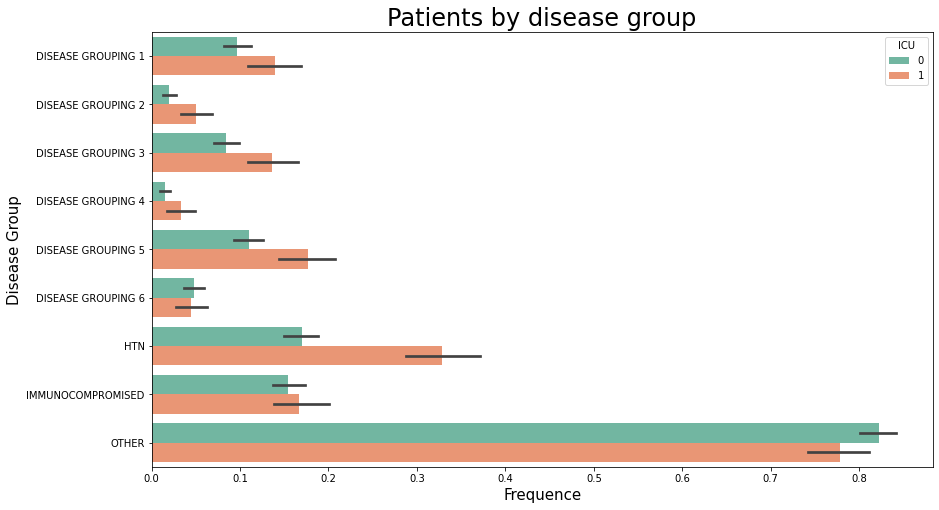

In [ ]:
plt.figure(figsize=(14,8))
sns.barplot(x='value', y='variable', data= diseases.melt(id_vars='ICU'),
            hue='ICU', orient='h', palette= 'Set2')
plt.title('Patients by disease group', fontsize=24, loc='center')
plt.xlabel('Frequence', fontsize=15)
plt.ylabel('Disease Group', fontsize=15);

#### **Which age demographic has the most diseases?**
From the latter question we see that people with a prior health condition have a higher chance of catching COVID-19, hence needing an **ICU**. In addition it also matters if a patient is below or above 65 years old to be assigned an **ICU**. It is worth checking if the **AGE_PERCENTIL** is connected to the diseases they have.

In [ ]:
diseases.insert(0, 'AGE_PERCENTIL', data['AGE_PERCENTIL'])

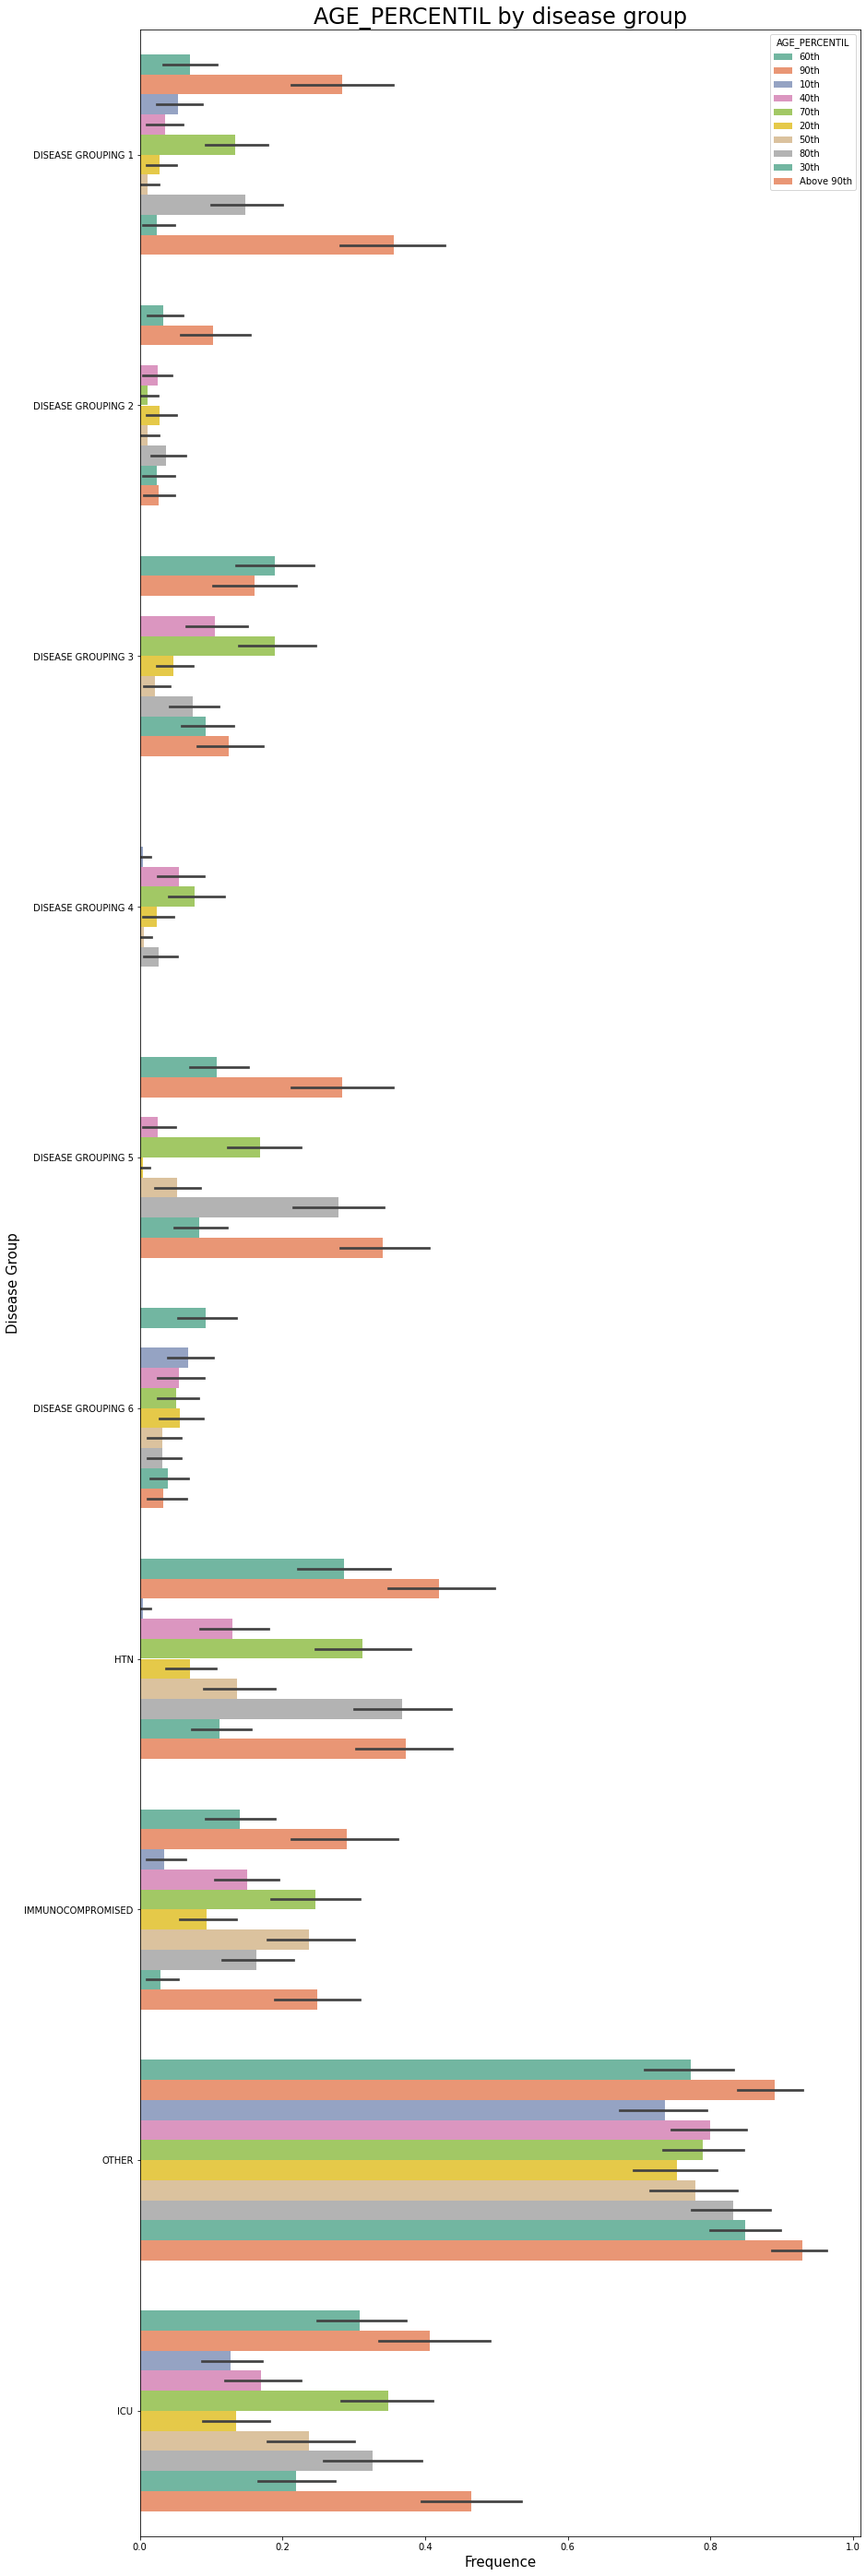

In [ ]:
plt.figure(figsize=(14,50))
sns.barplot(x='value', y='variable', data= diseases.melt(id_vars='AGE_PERCENTIL'),
            hue='AGE_PERCENTIL', orient='h', palette= 'Set2')
plt.title('AGE_PERCENTIL by disease group', fontsize=24, loc='center')
plt.xlabel('Frequence', fontsize=15)
plt.ylabel('Disease Group', fontsize=15);

#### **How many ICU's are there per WINDOW?**
As the authors of the dataset have mentioned we need to be careful when the **ICU** target value is 1, because the lab results could or could not have been ready before the **ICU** admission. We will have to take this into consideration when preparing the data to be given to the models.

In [ ]:
pd.crosstab(data.WINDOW, data.ICU)

ICU,0,1
WINDOW,,
0-2,353,32
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


## Data Preparation
Before we give the data to the machine learning models, we have to find a way to prepare the data into numbers that can help us predict, in order to make predictions and make them as accurate as possible. 

### Windows
We should be careful when the **ICU** is 1 because the lab results may or may have not been ready before the **ICU** admission. Hence patients with a **WINDOW** 0-2 and **ICU** of 1 will be discarded.

In [ ]:
# Remove unreliable data
data = data.drop(data[(data['WINDOW'] == '0-2') & (data['ICU'] == 1)].index)
pd.crosstab(data.WINDOW, data.ICU)

ICU,0,1
WINDOW,,
0-2,353,0
2-4,326,59
4-6,286,99
6-12,255,130
ABOVE_12,190,195


Now the dataset does not have any invalid cases (`data.ICU == 1 & data.WINDOW == '0-2'`). However because there are not enough records for the model to learn, we will use all of the `WINDOW` variables, rather than only `data.WINDOW == '0-2'`.

### Non-numeric columns
In order for the machine learning algorithms to work with the data we need to convert the `object` columns to numbers.

In [ ]:
print("Non-numeric columns that need to be converted: \n\n{}" .format(data.select_dtypes(object).columns))

Non-numeric columns that need to be converted: 

Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')


Let's check the columns values and see how we can encode them.

In [ ]:
for column in data.select_dtypes(object).columns:
  print(column)
  print(data[column].unique())
  print("\n")

AGE_PERCENTIL
['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']


WINDOW
['0-2' '2-4' '4-6' '6-12' 'ABOVE_12']




The labels are categorical and wew ill use `LabelEncoder` to encode the target values.

In [ ]:
le = LabelEncoder()

for column in data.select_dtypes(object).columns:
  data[column] = le.fit_transform(data[column])

In [ ]:
# Double check the dtypes of all of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(6)
memory usage: 3.4 MB


The entire dataset has been converted to numerical values. However the dataset has too many columns and we could possibly have the curse of dimensionality. When having too many features, observations are more likely to appear equidistant from all the others.

### Dimensionality reduction
The dataset has more than 200 features and that can prevent the model from making accurate predictions and capture the essence of the data. In order to provide better predictive scorses, we will use **PCA** before we use **Random Forest** to reduce the dimentions of the dataset.

#### Principal Component Analysis
PCA is used to reduce the dimensions of the dataset so the computational power to run the model is reduced. 

Before we reduce the features of the dataset let's check what would be the ideal number of features. PCA studies the cumulative explained variance ratio of the dataset's features to understand which of them explain the most variance in the data. To begin with, we will start with a Scree Plot of the number of features.

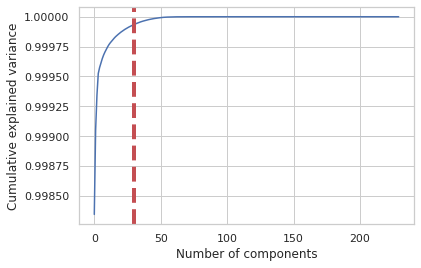

In [ ]:
pca = PCA(n_components=len(data.columns) - 1)
x_data = data.drop(labels=['ICU'], axis=1)

pca.fit(x_data)

# Plot the number of components that will be considered
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=30, ymin=0, ymax=1)
plt.show()

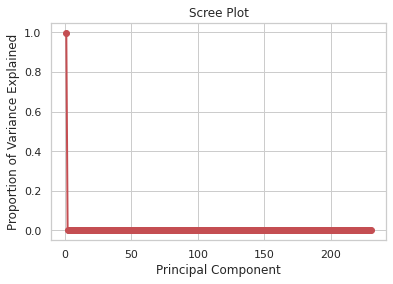

In [ ]:
values = np.arange(pca.n_components_) + 1
plt.plot(values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

The Scree Plot does not give us any information so we will use the Cumulative explained variance to see how many features should be left. It looks like 30 features are enough for the dataset to be optimized based on the Cumulative explained variance. Now we can run `PCA` to reduce the number of components.

In [ ]:
pca = PCA(n_components=30)
x_data = data.drop(labels=['ICU'], axis=1)
pca.fit(x_data)

pca_data = pca.transform(x_data)

In [ ]:
pca_columns = []

for x in range (0, pca_data.shape[1]):
  pca_columns.append("PCA Component {}" .format(x))

pca_data = pd.DataFrame(data=pca_data, columns = pca_columns)

In [ ]:
print("Datashape before:\t{}\n" .format(data.shape))
print("Datashape after:\t{}" .format(pca_data.shape))

Datashape before:	(1893, 231)

Datashape after:	(1893, 30)


#### Random Forest
After running **PCA** on the dataset, now we can run `RandomForestClassifier` to check if there are any improvements on the model's predictions. 

In [ ]:
# Split the data into X and Y variables
x = pca_data
y = data['ICU']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model with all of the data
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

Now that the `RandomForestClassifier` model is trained we can visualize the feature importance of the model.

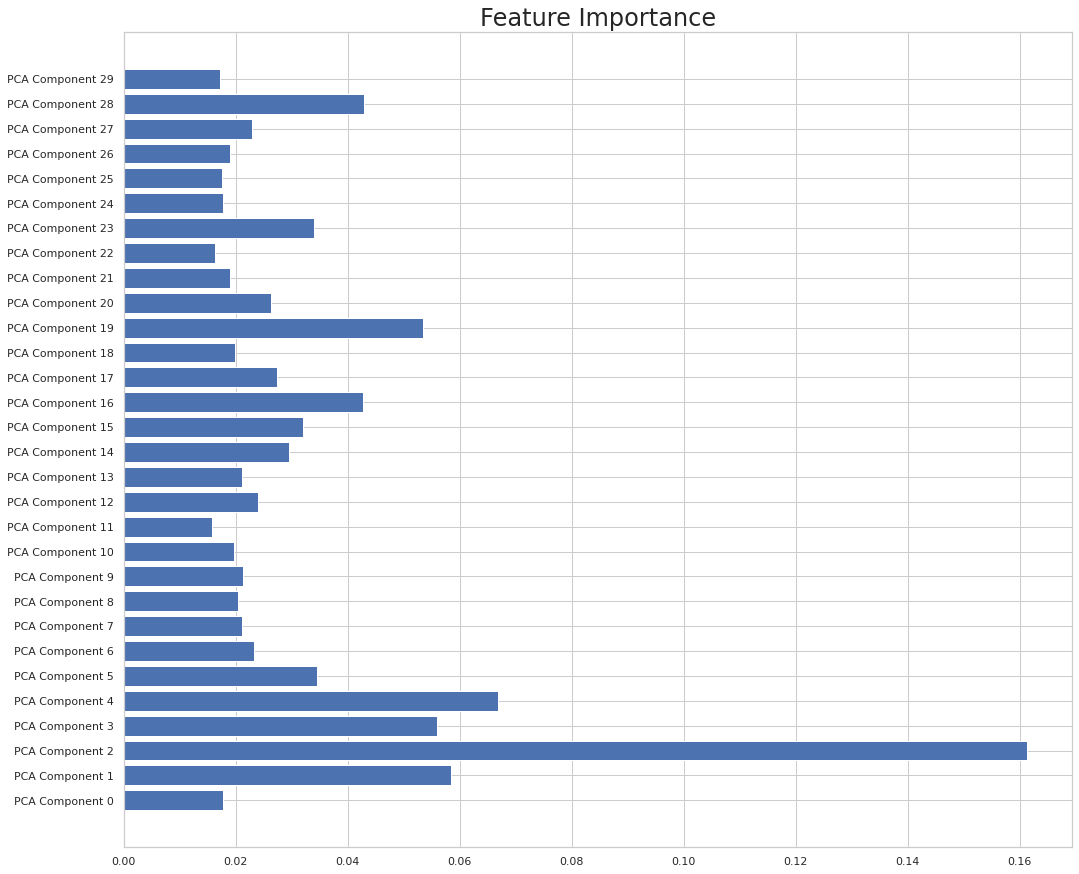

In [ ]:
features = []
values = []

# Get the feature name and the importance
for feature, importance in zip(pca_data.columns, rfc.feature_importances_):
    features.append(feature)
    values.append(importance)

plt.figure(figsize=(17, 15))
plt.title("Feature Importance", fontsize=24)
plt.barh(features, values)
plt.show()

Now that the importance is also visualized, we can select the columns which contribute the most to the final predictions and remove the less contributing columns.

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(x_train, y_train)

columns = sel.get_support()

print("Columns to be removed from: {}\n" .format(pca_data.loc[:, ~columns].columns.values))
print("Columns to be kept: {}" .format(pca_data.loc[:, columns].columns.values))

cleaned_data = pca_data.loc[:, columns]

Columns to be removed from: ['PCA Component 0' 'PCA Component 5' 'PCA Component 6' 'PCA Component 7'
 'PCA Component 8' 'PCA Component 9' 'PCA Component 10' 'PCA Component 11'
 'PCA Component 12' 'PCA Component 13' 'PCA Component 14'
 'PCA Component 15' 'PCA Component 17' 'PCA Component 18'
 'PCA Component 20' 'PCA Component 21' 'PCA Component 22'
 'PCA Component 24' 'PCA Component 25' 'PCA Component 26'
 'PCA Component 27' 'PCA Component 29']

Columns to be kept: ['PCA Component 1' 'PCA Component 2' 'PCA Component 3' 'PCA Component 4'
 'PCA Component 16' 'PCA Component 19' 'PCA Component 23'
 'PCA Component 28']


We have cleaned the data and removed the redundant features. Now we can move on to developing machine learning models. The data will not be scaled - the data has already been scaled for us.

## Models
The missing data has been dealt with and the data has been prepared for the machine learning models. We have skipped the scaling step for the dataset because the data was initially scaled.
<br/><br/>
### How to deal with unbalanced dataset?

There are 2 ways of dealing with - **SMOTE** and **Class Weights**. 
<br/><br/>
**SMOTE - Synthetic Minority Oversampling Technique**

We will not use undersampling because that means that we will lose a big part of the dataset and models will underfit. On the other hand oversampling is more computationally expensive but no data is lost compared to undersampling. In this case the data is 50% ICU and 50% non ICU target values. However Random Over-Sampling randomly copies more minority observations by replication. Although no information is lost meaning that the models will overfit.

**SMOTE** is another approach to handle imbalanced datasets. It evens out the minority class but without copying already existing data. This technique synthesises new minority data points between existing minority instances.

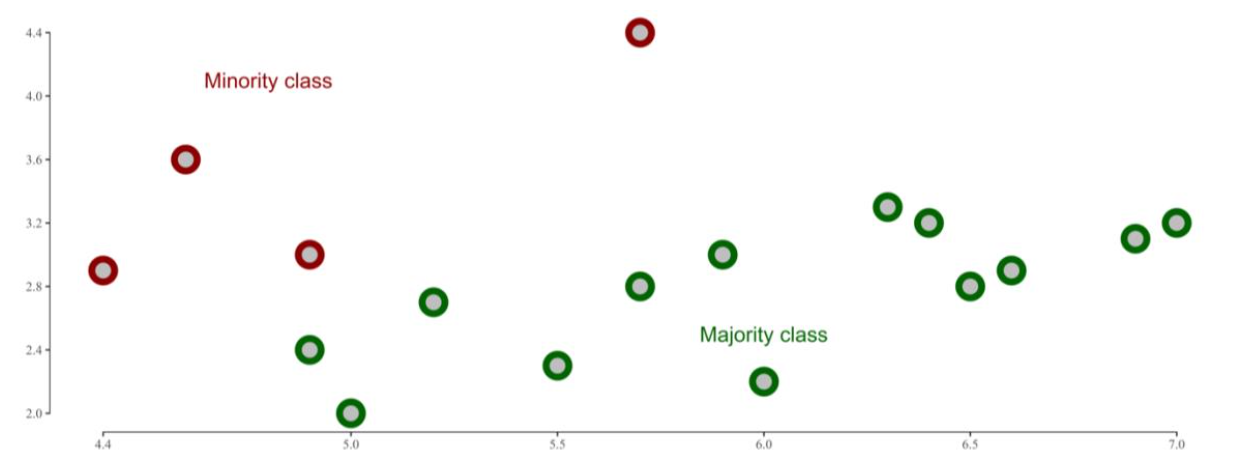

Initially the algorithm plots down every data point. Then the feature vector and the data point’s nearest neighbours are identified. The difference between the two vectors is calculated and their difference is multiplied by a random number between 0 and 1. Finally the new point is identified on the line segment by adding the random number to feature vector.

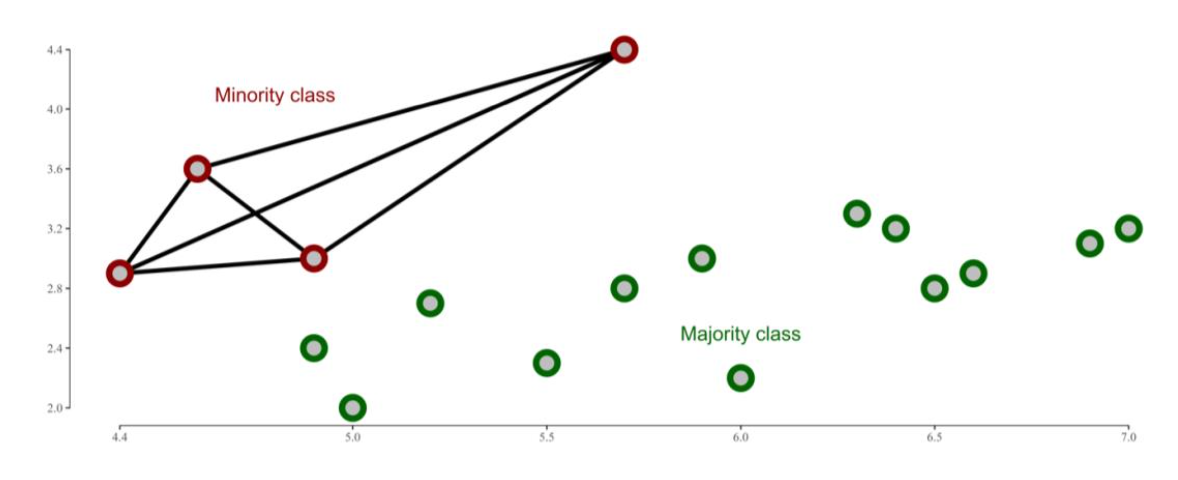
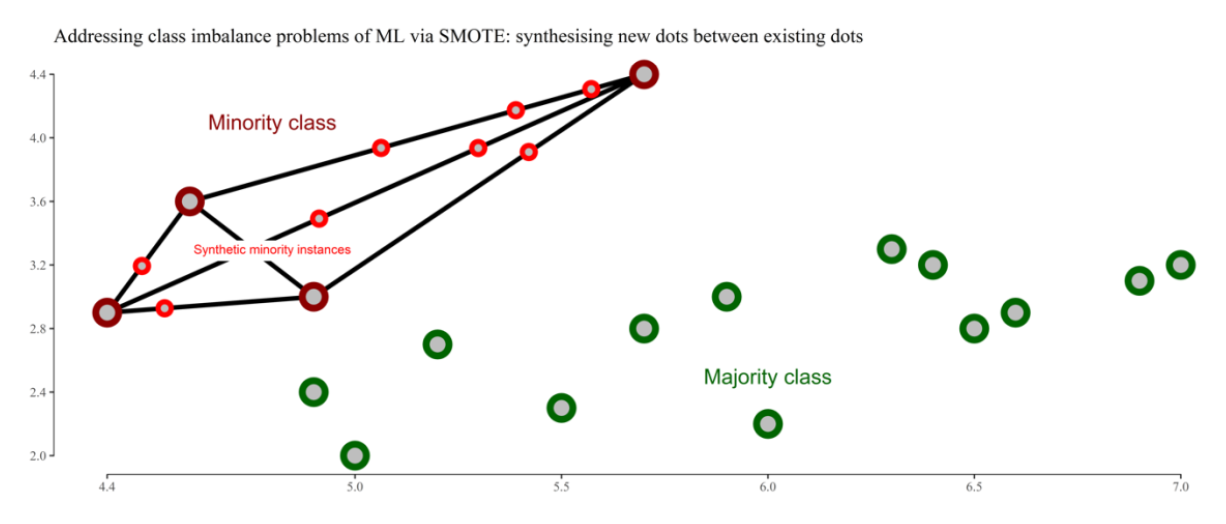
<br/><br/>
**Class Weights**

In general machine learning algorithms do not take into consideration if the dataset is imbalanced, meaning that there will be an equal penalization for misclassifying a correct and wrong example. However, in imbalanced datasets if a minority class is misclassified the penalization has to be higher than the penalization of misclassifying a correct example. When implementing the algorithm, the class weight is turned off by default, giving both classes equal weights.
<br/><br/>
### Data scaling

We do not have enough data to split the model into train, validation and test. We will split the data the traditional way - train and test.

In [ ]:
# Split the data into train and test
x = pca_data
y = data['ICU']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Create SMOTE data
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x, y)

print("Normal data:\t{}\n". format(Counter(y)))
print("SMOTE data:\t{}". format(Counter(y_smote)))

# Split SMOTE data into train and test 
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

Normal data:	Counter({0: 1410, 1: 483})

SMOTE data:	Counter({0: 1410, 1: 1410})


### Metrics
In order to train the model correctly, we will have to evaluate how well the predictions are compared to the true values.
<br><br>
#### Confusion Matrix
- **True Positive** - **TP** [ 0 ] [ 0 ] - How many patients did not need an ICU.

- **False Positive** - **FP** [ 0 ] [ 1 ] - How many patients did not need an ICU but were predicted as ICU.

- **False Negative** - **FN** [ 1 ] [ 0 ] - How many patients needed an ICU but did not get one.

- **True Negative** - **TP** [ 1 ] [ 1 ] - How many patients needed an ICU.


**Recall** tells us how many of the true positives were found and **Precision** is used to calculate the quality of a positive prediction made. However we will not be using **Accuracy** because the dataset target values are imbalanced. This creates the **Accuracy Paradox**. Good performance on the minority class will be preferred over good performance on both classes.

**F1** is used to check if there are a low **FP** and **FN** predictions and identify the real predictions. The closer **F1** is to 1, the better the algorithm is doing predicting correctly **TP** and **TN** examples. 

In [ ]:
# Print out the confusion matrix, Recall, Percision, F1 score and ROC curve.
def showReport(y_test, predictions):
  # Get confusion matrix results
  results = confusion_matrix(y_test, predictions)
  # True Positive
  TP = results[0][0]
  # False Positive
  FP = results[0][1]
  # False Negative
  FN = results[1][0]
  # True Negative
  TN = results[1][1]

  print("TP = {:<4}\t\t\tFP = {:<4}\n" .format(TP, FP))
  print("FN = {:<4}\t\t\tTN = {:<4}\n" .format(FN, TN))

  print("Recall = {}%\n" .format(round(recall_score(y_test, predictions), 2) * 100,))
  print("Precision = {}%\n" .format(round(precision_score(y_test, predictions), 2) * 100))
  print("F1 score = {}%\n" .format(round(f1_score(y_test, predictions), 2) * 100))
  
  # Get ROC data
  random_probs = [0 for i in range(len(y_test))]
  p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

  fpr, tpr, thresh = roc_curve(y_test, predictions)

  # Plot ROC curves
  plt.plot(fpr, tpr, linestyle='--',color='orange')
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
  
  # Title
  plt.title('ROC curve', fontsize=20)
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')

  plt.show();

In [ ]:
# Compare the algorithm performance based on F1 score
def compare_algorithms(names, results, alg_name):
  ranking = pd.DataFrame()
  ranking["Name"] = names
  ranking["F1"] = results
  ranking = ranking.sort_values('F1')

  plt.figure(figsize=(8, 5))
  plt.barh(ranking["Name"], ranking["F1"])
  plt.title(alg_name)
  plt.xlabel("F1 score")
  plt.show()

In [ ]:
# Create Pandas DataFrame for algorithm and their F1 scores
def create_df(names, results, alg_name):
  algorithm = pd.DataFrame() 
  algorithm["Name"] = names
  # Add the algorithm's name in front
  algorithm["Name"] = alg_name + " " + algorithm["Name"]
  algorithm["F1"] = results

  return algorithm

In [ ]:
# Helper function that returns the F1 score (number between 1 and 100)
def f1_score_percentage(y_test, predictions):
  return round(f1_score(y_test, predictions), 2) * 100

In [ ]:
# Set the class weights so they are equal everywhere
weights = {0: 1, 1: 100}

In order to get the most accurate model, we will have to find the best hyperparameters from a given set. `GridSearchCV` goes through all of the possible parameter combinations and chooses the best performing one as best parameters. 

To speed up the computation, we will also use `HalvingGridSearchCV`. Similar to `GridSearchCV`, the halving method trains the models on smaller portions of the training data. On the next iteration, only candidates who performed best will be used etc.

### Base comparison
In order for us to proceed with the best algorithms, we will compare them how they perform on the dataset with their default settings, with the exception of turning on `class_weight` to make up for the data imbalance.

We will use `names` and `performance` to plot how compare them by F1 score.

In [ ]:
# Store the algorithm names
names = []
# Store algorithm performance
performance = []

#### Logistic Regression
The fundamental idea of logistic regression is to use a linear prediction function of linear regression to estimate what the probability of the variable being 0 or 1 for a given set of observations.

TP = 88  			FP = 187 

FN = 0   			TN = 104 

Recall = 100.0%

Precision = 36.0%

F1 score = 53.0%



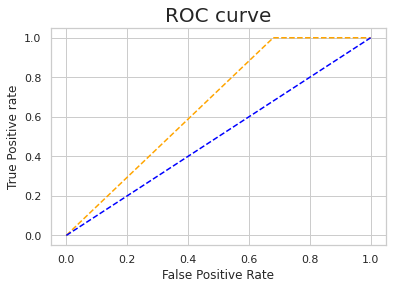

In [ ]:
lr = LogisticRegression(class_weight=weights)

lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Logistic Regression")
performance.append(f1_score_percentage(y_test, predictions))

Without any parameters (with the exception of `class_weight`) Logistic regression has an average performance as a first algorithm. Let's run the rest and compare the results

#### Support Vector Machine
SVM is one of the most popular algorithms for numerical predictions and classification. This algorithm generates the best decision boundary in an iterative way. It aims to maximize the distance between the different classes and minimuse the prediction error.

TP = 0   			FP = 275 

FN = 0   			TN = 104 

Recall = 100.0%

Precision = 27.0%

F1 score = 43.0%



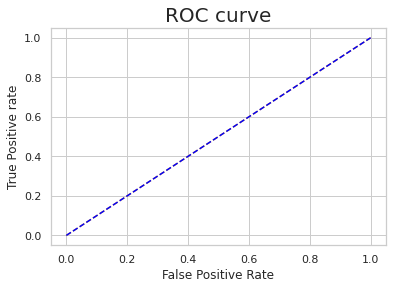

In [ ]:
svmc = svm.SVC(class_weight=weights)

svmc.fit(x_train, y_train)
predictions = svmc.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Support Vector Machine")
performance.append(f1_score_percentage(y_test, predictions))

Logistic Regression is performing slightly better than Support Vector Machine without even being tuned.

#### Random Forest

Random Forests is a supervised machine learning algorithm that is based on ensemble learning. This algorithm combines multiple decision trees, which forms a forest. Initially every tree has the same weight towards the end result. The final result is processed by checking which answer has highest votes. Random Forests can be used for both regression and classification tasks.

TP = 269 			FP = 6   

FN = 58  			TN = 46  

Recall = 44.0%

Precision = 88.0%

F1 score = 59.0%



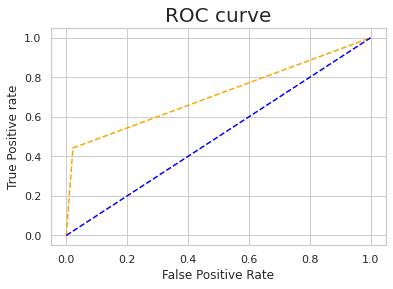

In [ ]:
rfc = RandomForestClassifier(class_weight=weights)

rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Random Forest")
performance.append(f1_score_percentage(y_test, predictions))

Random Forest is doing slightly better than Logistic Regression (by 3%) and 13% better than Support Vector Machine.

#### XGBoost
XGBoost is an ensemble algorithm that combines weak learners to form a strong learner and increase the accuracy of the model. Rules help identify a specific class. If a class is identified on an individual learner then the prediction is flawed. Multiple rules are used before determining the class of the final output.

In **Gradient Boosting**, the base learners are generated sequentially that the current base learner is more effective from its predecessor. The loss function is optimized of the previous learner. **Extreme Gradient Boosting** has high speed and performance. It is used for regression and classification problems. **XGBoost** is used as a starting point to make accurate predictions for other models. This algorithm supports:

- **Parallelization** - the algorithm uses maximum available computational power
- **Cache optimization** - keeps its calculations in the cache and fetches it fast to perform calculations
- **Out of memory computation** - XGBoost can work with data that is more than the available space.
- **Regularization** - prevents the model of overfitting
- **Missing values** - takes care of missing values in a dataset


TP = 157 			FP = 118 

FN = 4   			TN = 100 

Recall = 96.0%

Precision = 46.0%

F1 score = 62.0%



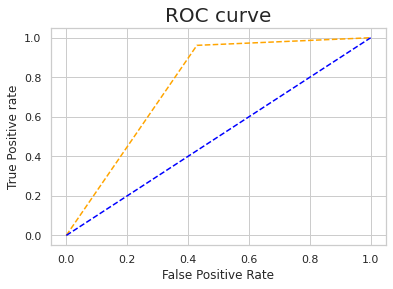

In [ ]:
xgbc = xgb.XGBClassifier(scale_pos_weight=100)

xgbc.fit(x_train, y_train)
predictions = xgbc.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("XGBoost")
performance.append(f1_score_percentage(y_test, predictions))

Compared to Logistic Regression and Support Vector Machine, XGBoost is doing the best so far and it is safe to consider it as an algorithm that we will further tune.

#### Multi-layer Perceptron
Multi-layer Perceptrons are inspired by biological neurons, which have dentrites and axons. An artificial neuron is called a **Perceptron** and it has inputs, a weight for every input, bias and an output.

The output is calculated from the summation of the input and weight products, including the bias pass through an activation function.

TP = 262 			FP = 13  

FN = 31  			TN = 73  

Recall = 70.0%

Precision = 85.0%

F1 score = 77.0%



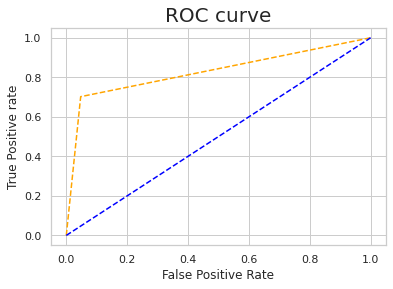

In [ ]:
# MLP does not have any weights to modify
mlp = MLPClassifier()
mlp.fit(x_train, y_train)

predictions = mlp.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Multi-layer Perceptron")
performance.append(f1_score_percentage(y_test, predictions))

So far the Multi-layer Perceptron has done the best job of classifying the data even though the data is unbalanced. It is worth further investigating how the algorithm will perform on **SMOTE** data as well.

#### K-Nearest Neighbours
K-Nearest Neighbours is a simple supervised machine learning algorithm that is used to solve classification and regression problems. This algorithm identifies the k nearest neighbours of new unlabelled data. **K** is the number of nearest neighbours that will be considered when deciding the data's class. A good practice is to choose an **odd K** number so the when deciding the class of the unlabelled data, one class has more votes than the other by one.

This algorithm is very easy to use and does not require a lot of maths. However, the cons are that it is memory intensive, new predictions take longer time and there is no real pre-processing. The bigger the **K** parameter is, the more time it will take to compute the label. 

TP = 256 			FP = 19  

FN = 62  			TN = 42  

Recall = 40.0%

Precision = 69.0%

F1 score = 51.0%



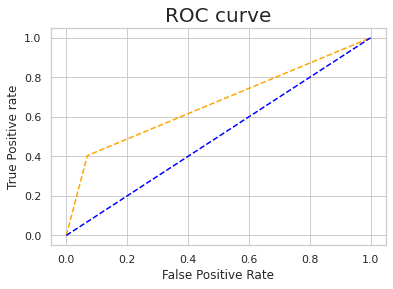

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

predictions = knn.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("K-Nearest Neighbour")
performance.append(f1_score_percentage(y_test, predictions))

K-Nearest Neighbours is one of the poorer performers, just slightly better than Support Vector Machine.

#### Gaussian Naive Bayes
The Gaussian Naive Bayes is a variant of Naive Bayes that follows the Gaussian normal distribution and supports continuous data. Out of the different Naive Bayes types, Gaussian Naive Bayes is used for classification.

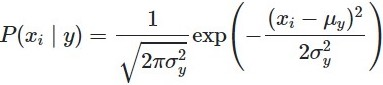

TP = 245 			FP = 30  

FN = 55  			TN = 49  

Recall = 47.0%

Precision = 62.0%

F1 score = 54.0%



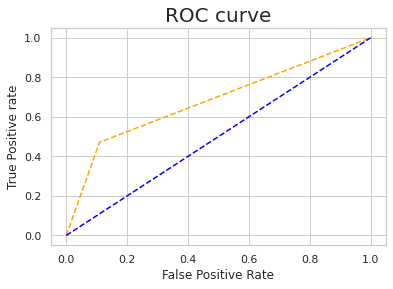

In [ ]:
gnb = GaussianNB()

gnb.fit(x_train, y_train)
predictions = gnb.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Gaussian Naive Bayes")
performance.append(f1_score_percentage(y_test, predictions))

Gaussian Naive Bayes is doing as good as Random Forest and slightly better than Logistic Regression. However Gaussian Naive Bayes does not have any hyperparameters to tune and it's performance might not increase. However we can further investigate if this algorithm is doing with **SMOTE** data.

#### Results
After running all of the algorithms and getting their **F1** scores, we can compare them against each other and decide which ones will proceed with hyper parameter tuning and which ones would be dropped.

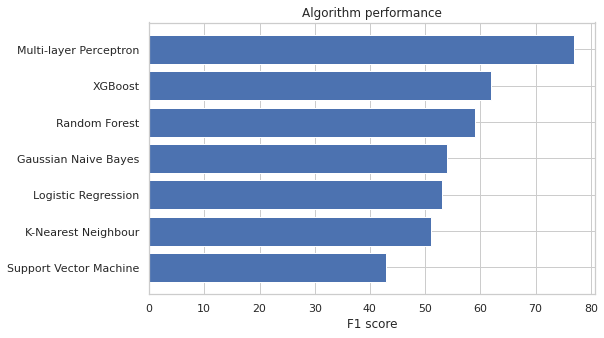

In [ ]:
compare_algorithms(names, performance, "Algorithm performance")

The algorithms we will proceed tuning are:
- **Multi-layer Perceptron** - even though the dataset's target values are unbalanced, we will further investigate with hyperparameter tuning and **SMOTE**
- **XGBoost** - the second best algorithm in **F1** performance only with tuning `scale_pos_weight`. This algorithm could possibly do even better with  hyperparameter tuning as well.
- **Random Forest** - as **XGBoost** they are in the same algorithm family (ensemble learning), we will further investigate how **Random Forest** will perform with hyperparameter tuning.
- **Gaussian Naive bayes** - although this algorithm performs almost as good as **Random Forest**, it does not have any hyperparameters to tune. However we will use **SMOTE** on it to see if the algorithm performs better if the data is balanced or not.
- **Logistic Regression** - although this algorithm performs slightly worse than **Gaussian Naive Bayes** it could perform better with hyperparameter tuning and **SMOTE**.
- **K-Nearest Neighbour** - although this algorithm is one of the poorer performers, we will further investigate if it can do better with **SMOTE**.

The algorithms that will not be further considered are:
- **Support Vector Machine** - has the poorest performance out of all of the other algorithms and is not worth further investigating.

### Model hyperparameter tuning
In this section we will tune the hyperparameters for the algorithms and compare their performance.

In [ ]:
# Store all of the results
final = pd.DataFrame()

In [ ]:
  # Get base algorithm performance
  algorithms = pd.DataFrame()
  algorithms["Name"] = names
  algorithms["F1"] = performance
  algorithms = algorithms.sort_values('F1')

#### Multi-layer Perceptron
The main parameter that we will be tuning is the `hidden_layer_sizes`, which modifies the number of neurons for each layer and the layer number. We will not be experimenting the `activation` and `solver`.

We will use `adam` as the `solver` because it is the fastest one to achieve high performing results.

We will use `relu` as the `activation` because, it is simplem fast and works well for deeper models, allowing the network to learn new data features.

In [ ]:
names = []
performance = []

names.append("No tuning")
performance.append(algorithms.loc[algorithms.Name == 'Multi-layer Perceptron', 'F1'].values[0])

##### Normal dataset

In [ ]:
parameters = {
    'hidden_layer_sizes': [(neurons, layers) for neurons in range(10, 110, 10) for layers in range(10, 110, 10)],
    'activation': ['relu'],
    'solver': ['adam']
}

mlp = MLPClassifier()
halving_grid = HalvingGridSearchCV(estimator=mlp, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train, y_train)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for Multi-layer Perceptron from all of the given ones is:

```
{
  'hidden_layer_sizes': (70, 20),
  'activation': 'relu',
  'solver': 'adam'
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.


TP = 251 			FP = 24  

FN = 25  			TN = 79  

Recall = 76.0%

Precision = 77.0%

F1 score = 76.0%



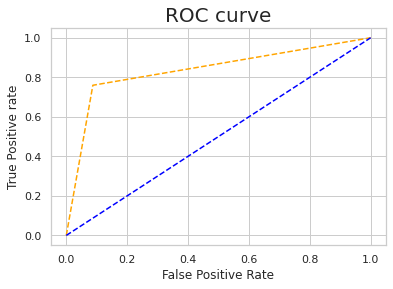

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(70, 20), activation='relu', solver='adam')
mlp.fit(x_train, y_train)

predictions = mlp.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Normal dataset")
performance.append(f1_score_percentage(y_test, predictions))

##### SMOTE

In [ ]:
parameters = {
    'hidden_layer_sizes': [(neurons, layers) for neurons in range(10, 110, 10) for layers in range(10, 110, 10)],
    'activation': ['relu'],
    'solver': ['adam']
}

mlp = MLPClassifier()
halving_grid = HalvingGridSearchCV(estimator=mlp, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_smote, y_train_smote)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for Multi-layer Perceptron from all of the given ones is:

```
{
  'hidden_layer_sizes': (60, 10),
  'activation': 'relu', 
  'solver': 'adam'
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.


TP = 263 			FP = 20  

FN = 39  			TN = 242 

Recall = 86.0%

Precision = 92.0%

F1 score = 89.0%



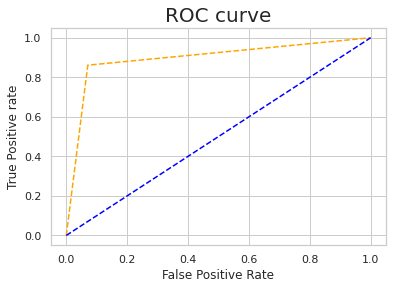

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 40), activation='relu', solver='adam')
mlp.fit(x_train_smote, y_train_smote)

predictions = mlp.predict(x_test_smote)

showReport(y_test_smote, predictions)

# Append algorithm details
names.append("SMOTE dataset")
performance.append(f1_score_percentage(y_test_smote, predictions))

##### Results

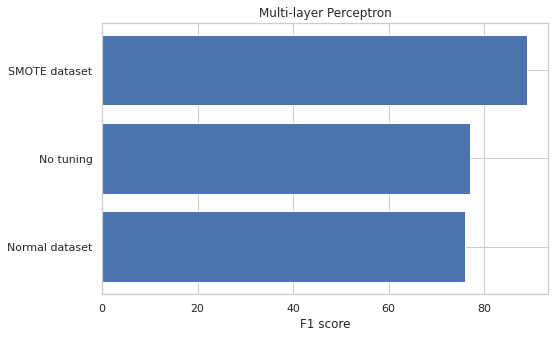

In [ ]:
compare_algorithms(names, performance, "Multi-layer Perceptron")

final = final.append(create_df(names, performance, "Multi-layer Perceptron"))

The **SMOTE** Multi-layer Perceptron has the best performance (93%) out of all of the MLP variations, proving that when the data is balanced MLP performs the best.

#### XGBoost

In [ ]:
names = []
performance = []

names.append("No tuning")
performance.append(algorithms.loc[algorithms.Name == 'XGBoost', 'F1'].values[0])

##### Normal dataset

In [ ]:
parameters = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'scale_pos_weight': [100]
}

xgbc = xgb.XGBClassifier()
halving_grid = HalvingGridSearchCV(estimator=xgbc, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train, y_train)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for XGBoost from all of the given ones is:

```
{
  'colsample_bytree': 0.8,
  'gamma': 0.5,
  'max_depth': 5,
  'min_child_weight': 1,
  'subsample': 1.0,
  'scale_pos_weight': 100
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.

TP = 218 			FP = 57  

FN = 11  			TN = 93  

Recall = 89.0%

Precision = 62.0%

F1 score = 73.0%



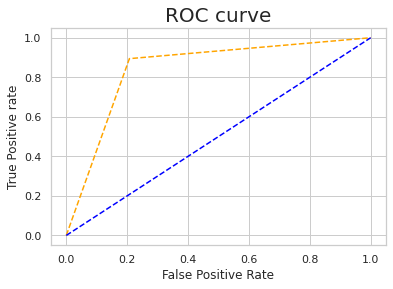

In [ ]:
xgbc = xgb.XGBClassifier(scale_pos_weight=100, colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=1, subsample=1)
xgbc.fit(x_train, y_train)
predictions = xgbc.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Normal dataset")
performance.append(f1_score_percentage(y_test, predictions))

##### SMOTE

In [ ]:
parameters = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

xgbc = xgb.XGBClassifier()
halving_grid = HalvingGridSearchCV(estimator=xgbc, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_smote, y_train_smote)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for XGBoost from all of the given ones is:

```
{
  'colsample_bytree': 0.6,
  'gamma': 1,
  'max_depth': 5,
  'min_child_weight': 1,
  'subsample': 0.6
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.

TP = 262 			FP = 21  

FN = 13  			TN = 268 

Recall = 95.0%

Precision = 93.0%

F1 score = 94.0%



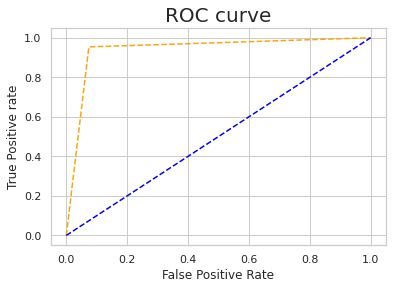

In [ ]:
xgbc = xgb.XGBClassifier(colsample_bytree=0.6, gamma=1, max_depth=5, min_child_weight=1, subsample=0.6)
xgbc.fit(x_train_smote, y_train_smote)
predictions = xgbc.predict(x_test_smote)

showReport(y_test_smote, predictions)

# Append algorithm details
names.append("SMOTE dataset")
performance.append(f1_score_percentage(y_test_smote, predictions))

##### Results

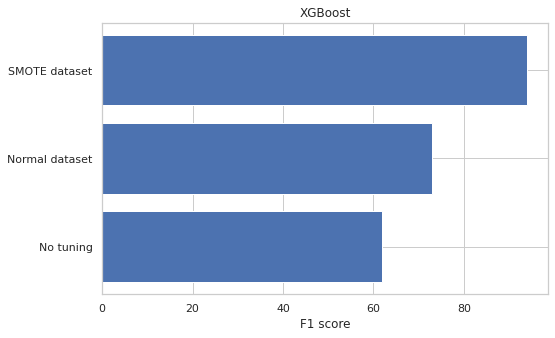

In [ ]:
compare_algorithms(names, performance, "XGBoost")

final = final.append(create_df(names, performance, "XGBoost"))

**SMOTE** XGBoost is performing as well as Multi-layer Perceptron with **SMOTE** (with 1% difference).

#### Gaussian Naive Bayes
This algorithm does not have any hyperparameters to tweak. The only test we can do is if the algorithm is performing better is by using **SMOTE** to balance the target values.

In [ ]:
names = []
performance = []

names.append("No tuning / Normal dataset")
performance.append(algorithms.loc[algorithms.Name == 'Gaussian Naive Bayes', 'F1'].values[0])

##### SMOTE

TP = 241 			FP = 42  

FN = 128 			TN = 153 

Recall = 54.0%

Precision = 78.0%

F1 score = 64.0%



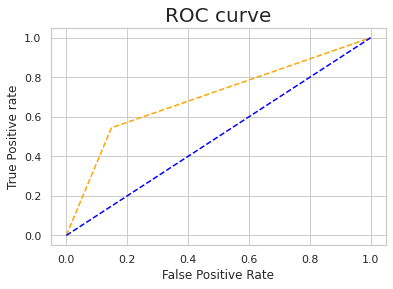

In [ ]:
gnb = GaussianNB()

gnb.fit(x_train_smote, y_train_smote)
predictions = gnb.predict(x_test_smote)

showReport(y_test_smote, predictions)

# Append algorithm details
names.append("SMOTE dataset")
performance.append(f1_score_percentage(y_test_smote, predictions))

##### Results

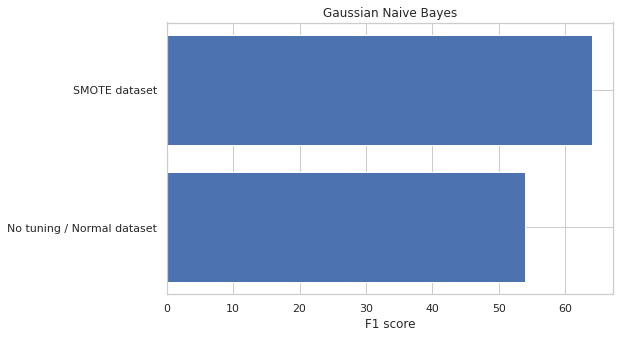

In [ ]:
compare_algorithms(names, performance, "Gaussian Naive Bayes")

final = final.append(create_df(names, performance, "Gaussian Naive Bayes"))

The **SMOTE** dataset is performing better than the normal / non tuning (which are the same in this algorithm's case). However this algorithm does not have a very good performance compared to Multi-layer Perceptron and XGBoost.

#### Random Forest

In [ ]:
names = []
performance = []

names.append("No tuning")
performance.append(algorithms.loc[algorithms.Name == 'Random Forest', 'F1'].values[0])

##### Normal dataset

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
parameters = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'class_weight': [weights],
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rfc = RandomForestClassifier()
halving_grid = HalvingGridSearchCV(estimator=rfc, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train, y_train)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for Random Forest from all of the given ones is:

```
{
  'bootstrap': True,
  'class_weight': {0: 1, 1:100},
  'max_depth': 60,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 1100
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.

TP = 270 			FP = 5   

FN = 63  			TN = 41  

Recall = 39.0%

Precision = 89.0%

F1 score = 55.00000000000001%



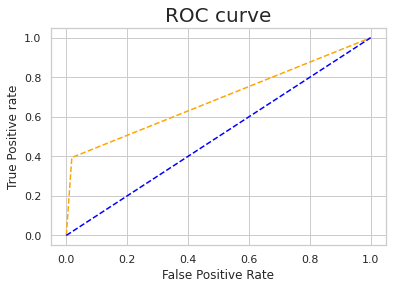

In [ ]:
rfc = RandomForestClassifier(class_weight=weights, bootstrap=True, max_depth=60, min_samples_leaf=1, min_samples_split=2, n_estimators=1100)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Normal dataset")
performance.append(f1_score_percentage(y_test, predictions))

##### SMOTE

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
parameters = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rfc = RandomForestClassifier()
halving_grid = HalvingGridSearchCV(estimator=rfc, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_smote, y_train_smote)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for Random Forest from all of the given ones is:

```
{
  'bootstrap': True,
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 2000
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.

TP = 257 			FP = 26  

FN = 14  			TN = 267 

Recall = 95.0%

Precision = 91.0%

F1 score = 93.0%



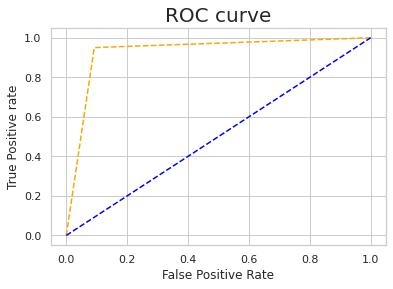

In [ ]:
rfc = RandomForestClassifier(bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000)
rfc.fit(x_train_smote, y_train_smote)
predictions = rfc.predict(x_test_smote)

showReport(y_test_smote, predictions)

# Append algorithm details
names.append("SMOTE dataset")
performance.append(f1_score_percentage(y_test_smote, predictions))

##### Results

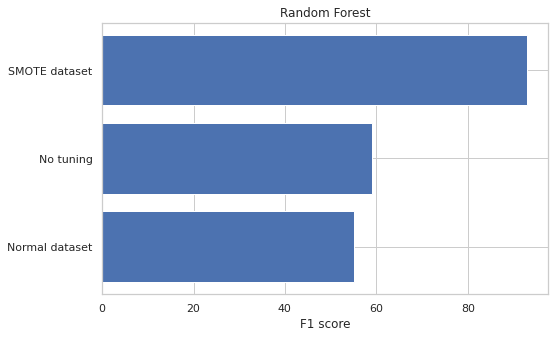

In [ ]:
compare_algorithms(names, performance, "Random Forest")

final = final.append(create_df(names, performance, "Random Forest"))

The normal dataset has the poorest performance. It can also be because there are not enough parameters in the `HalvingGridSearchCV` space. However the **SMOTE** dataset has the best performance with the same parameter space.

#### Logistic Regression

In [ ]:
names = []
performance = []

names.append("No tuning")
performance.append(algorithms.loc[algorithms.Name == 'Logistic Regression', 'F1'].values[0])

##### Class Weight

In [ ]:
parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [{0: 1, 1: 100}]
}

lr = LogisticRegression()
halving_grid = HalvingGridSearchCV(estimator=lr, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
halving_grid.fit(x_train, y_train)
print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 168
max_resources_: 1514
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 15
n_resources: 168
Fitting 3 folds for each of 15 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 5
n_resources: 504
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 2
n_resources: 1512
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best parameters:

{'C': 100, 'class_weight': {0: 1, 1: 100}, 'penalty': 'l2', 'solver': 'liblinear'}


The best set of parameters for Logistic Regression from all of the given ones is:

```
{
  'C': 100,
  'class_weight': {0: 1, 1: 100}, 
  'penalty': 'l2', 
  'solver': 'newton-cg'
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.


TP = 93  			FP = 182 

FN = 0   			TN = 104 

Recall = 100.0%

Precision = 36.0%

F1 score = 53.0%



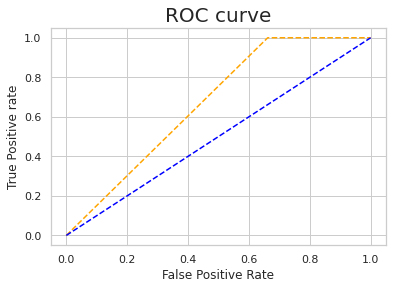

In [ ]:
lr = LogisticRegression(C=100, class_weight={0: 1, 1: 100}, penalty='l2', solver='newton-cg')
lr.fit(x_train, y_train)

predictions = lr.predict(x_test)

showReport(y_test, predictions)

# Append algorithm details
names.append("Normal dataset")
performance.append(f1_score_percentage(y_test, predictions))

Logistic regression with class weights is having issues correctly identifying False Positives (patients who need an ICU but did not get one) points.

##### SMOTE

In [ ]:
parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100]
}

lr = LogisticRegression()
halving_grid = HalvingGridSearchCV(estimator=lr, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_smote, y_train_smote)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for Logistic Regression from all of the given ones is:

```
{
  'C': 100,
  'penalty': 'l2', 
  'solver': 'lbfgs'
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.


TP = 238 			FP = 45  

FN = 49  			TN = 232 

Recall = 83.0%

Precision = 84.0%

F1 score = 83.0%



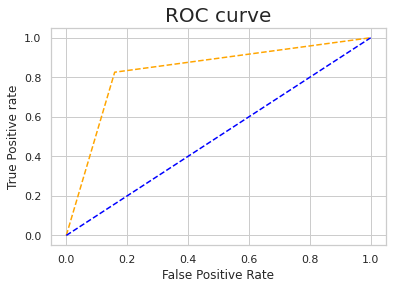

In [ ]:
lr = LogisticRegression(C=100, penalty='l2', solver='lbfgs')
lr.fit(x_train_smote, y_train_smote)

predictions = lr.predict(x_test_smote)

showReport(y_test_smote, predictions)

# Append algorithm details
names.append("SMOTE dataset")
performance.append(f1_score_percentage(y_test_smote, predictions))

##### Results

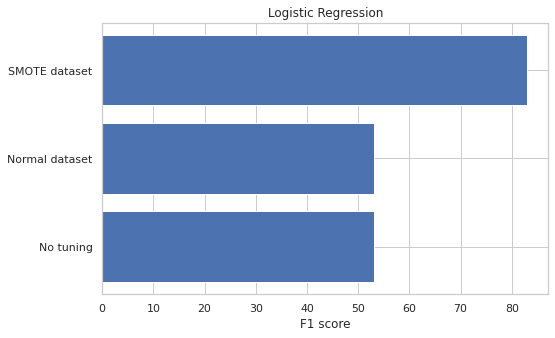

In [ ]:
compare_algorithms(names, performance, "Logistic Regression")

final = final.append(create_df(names, performance, "Logistic Regression"))

Logistic regression with the SMOTE dataset is doing slightly better at correctly identifying ICU cases (based on F1 score) but not good enough to be practically used. This algorithm is performing better than Gaussian Naive Bayes and almost as good as Multi-layer Perceptron and XGBoost.

#### K-Nearest Neighbour

In [ ]:
names = []
performance = []

names.append("No tuning")
performance.append(algorithms.loc[algorithms.Name == 'K-Nearest Neighbour', 'F1'].values[0])

##### SMOTE

In [ ]:
parameters = {
    'n_neighbors': [n for n in range(3, 40, 2)],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
halving_grid = HalvingGridSearchCV(estimator=knn, param_grid=parameters, cv=3, n_jobs=-1, verbose=10)

In [ ]:
# This section is commented because it takes a lot of time to compute
# halving_grid.fit(x_train_smote, y_train_smote)
# print("\nBest parameters:\n\n{}" .format(halving_grid.best_params_))

The best set of parameters for K-Nearest Neighbour from all of the given ones is:

```
{
  'n_neighbors': 3,
  'weights': 'distance'
}
```
Now we can run the algorithm with them and see how it is doing predicting the data.

TP = 244 			FP = 39  

FN = 12  			TN = 269 

Recall = 96.0%

Precision = 87.0%

F1 score = 91.0%



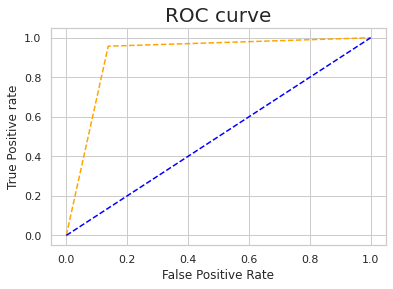

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(x_train_smote, y_train_smote)

predictions = knn.predict(x_test_smote)

showReport(y_test_smote, predictions)

# Append algorithm details
names.append("SMOTE dataset")
performance.append(f1_score_percentage(y_test_smote, predictions))

##### Results

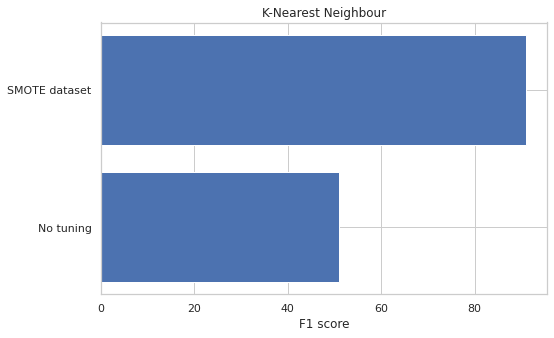

In [ ]:
compare_algorithms(names, performance, "K-Nearest Neighbour")

final = final.append(create_df(names, performance, "K-Nearest Neighbour"))

When the data is balanced, K-Nearest Neighbour has one of the best performance from all of the algorithms but KNN slows down when more data is given to it, because it has to calculate even more distances for the new data points in order to make a prediction.

#### Final results

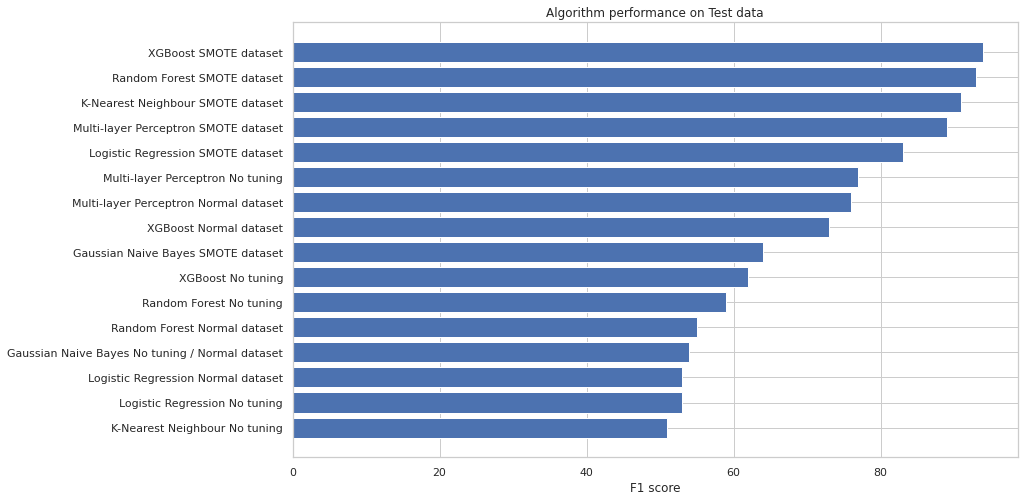

In [ ]:
# Sort algorithms by performance
final = final.sort_values('F1')

plt.figure(figsize=(13, 8))
plt.barh(final["Name"], final["F1"])
plt.title("Algorithm performance on Test data")
plt.xlabel("F1 score")
plt.show()

Overall the **SMOTE** algorithms have a way better performance than algorithms that use class weights to make up for the unbalanced target values. The best performers are **SMOTE** Random Forest, Multi-layer Perceptron and XGBoost. Random Forest and Multi-layer Perceptron have the same **F1** score - 94%. XGBoost is on second place with 93% and K-Nearest Neighbour is on 3rd place with 91%.

Even though K-Nearest Neighbour with **SMOTE** does a good job at accurately predicting if a patient needs an ICU or not, it is not very practical because with more data, the algorithm becomes slower and slower because it has to calculate the distance between the new data point and all the other data points in order to correctly classify it. With a bigger dataset this can be problematic and KNN will not be considered.

The dataset's unbalanced target values has crucial impact on the algorithms' performences which also leads them to underfitting. The **SMOTE** algorithms are not overfitting.

**NOTE**: The final results are based on the test data - `x_test` or `x_test_smote`.

# Conclusion

Overall this notebook goes over the [COVID-19 - Clinical Data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) dataset. Firstly we explroed and visualized the data and then we dealt with the **NaN** values. Then we prepared the data so it can be giving to the models - dealing with non-numeric values, clearing 0-2 **ICU** 1 target values and finally we performed **PCA** and **Random Forest** to the dataset in order to reduce the number of features. 

Afterwards we discussed what would be the best metrics to measure if the algorithms are performing good or bad - F1 score.

Finally we developed different machine learning models with different techniques (SMOTE, Class Weights and Halving Grid Search) to find the best performing models.

**SMOTE** algorithms have a better performance and if we had to design a model for the Sírio-Libanês hospital, we would suggest them to use **XGBoost SMOTE** to get the most accurate predictions.

# Thank you for your time ㋡